# LSTM based Sentiment Prediction and Recommender

## This notebook is divided into three parts as shown below:
### 1. Recommenders- Collaborative Filtering (Unsupervised and Supervised KNN).
### 2. LSTM Sentiment Prediction.
### 3. Recommenders- Content-Based Recommender.

#### Import libraries

In [420]:
import pandas as pd
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 1. Recommenders!! (Collaborative Filtering using KNN)

In [5]:
#Taking 1st 500k data from Amazon data set for training and validation purposes
data500=pd.read_json('500data.json',lines=True)

In [153]:
#df2 = data500.pivot_table(values='overall',index='reviewerID',columns='asin')

In [278]:
data500.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [279]:
data500.shape

(500000, 9)

In [280]:
print(f"Number of unique products in the dataset:{len(data500.asin.unique())}")

Number of unique products in the dataset:19839


In [281]:
print(f"Number of unique users in the dataset:{len(data500.reviewerID.unique())}")

Number of unique users in the dataset:155870


In [282]:
count = data500.groupby("asin", as_index=False).count()
mean = data500.groupby("asin", as_index=False).mean()
dfMerged = pd.merge(data500, count, how='right', on=['asin'])

In [283]:
count.head()

,asin,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0528881469,5,5,5,5,5,5,5,5
1,0594451647,5,5,5,5,5,5,5,5
2,0594481813,8,8,8,8,8,8,8,8
3,0972683275,219,218,219,219,219,219,219,219
4,1400501466,43,43,43,43,43,43,43,43


In [284]:
count.shape

(19839, 9)

In [285]:
mean.head()

,asin,overall,unixReviewTime
0,0528881469,2.400000,1.310515e+09
1,0594451647,4.200000,1.396328e+09
2,0594481813,4.000000,1.382789e+09
3,0972683275,4.461187,1.354240e+09
4,1400501466,3.953488,1.352373e+09


In [286]:
mean.shape

(19839, 3)

In [287]:
#mean=mean.rename(columns={'asin': 'productID'})

In [288]:
dfMerged.shape

(500000, 17)

In [289]:
dfMerged.head()

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013",5,5,5,5,5,5,5,5
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010",5,5,5,5,5,5,5,5
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010",5,5,5,5,5,5,5,5
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010",5,5,5,5,5,5,5,5
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011",5,5,5,5,5,5,5,5


In [290]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]
dfMerged["UserID"]=dfMerged['reviewerName_x']
dfNew = dfMerged[['asin','UserID','summaryReview','overallScore',"totalReviewers"]]


In [235]:
#dfNew=dfNew.rename(columns={'asin': 'productID'})

In [291]:
dfNew.head()

,asin,UserID,summaryReview,overallScore,totalReviewers
0,0528881469,amazdnu,Gotta have GPS!,5,5
1,0528881469,Amazon Customer,Very Disappointed,1,5
2,0528881469,C. A. Freeman,1st impression,3,5
3,0528881469,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",2,5
4,0528881469,Wayne Smith,"Major issues, only excuses for support",1,5


In [292]:
dfNew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   asin            500000 non-null  object
 1   UserID          495825 non-null  object
 2   summaryReview   500000 non-null  object
 3   overallScore    500000 non-null  int64 
 4   totalReviewers  500000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 22.9+ MB


In [293]:
dfNew.shape

(500000, 5)

In [299]:
dfNew=dfNew[dfNew['totalReviewers']>=10]

In [300]:
dfNew=dfNew.rename(columns={'asin':'productID','overallScore':'rating'})

In [301]:
dfNew.head()

,productID,UserID,summaryReview,rating,totalReviewers
18,0972683275,NaN,Excelant mount for Tv. Would buy more if I nee...,5,219
19,0972683275,2Cents!,Perfect,5,219
20,0972683275,AGW,32 In TV Mount,5,219
21,0972683275,ahoffoss,"Pretty simple, but definitely good!",4,219
22,0972683275,"Alberto Dieguez ""premiere purchaser of random...",Fairly good wall mount,4,219


In [302]:
len(dfNew.productID.unique())

10787

In [303]:
sim_table=dfNew.pivot_table('rating',index='productID',columns='UserID').fillna(0)

In [304]:
sim_table.head()

UserID,,," ""Top 100 Amazon Reviewer""","Leah ""Leah""","! MR. KNOW IT ALL ;-b ""DR SHOCK""",!!!,!@#$%^&amp;*()_+=-,"""The Woj""","""Van""","""amazonreader""",...,~:TLH:~,~Astro~,"~AudioBookaHolic~ ""Issy""",~Kimber~,~Miss~,"~R~ ""Money Hunter""",~Shawn~,~joy~,"~purplemoon~ ""The Quiet Corner""",~~~
productID,,,,,,,,,,,,,,,,,,,,,
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400532620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [305]:
sim_table.shape

(10786, 129499)

In [120]:
from scipy.sparse import csr_matrix

In [121]:
matrix=csr_matrix(sim_table.values)

In [122]:
from sklearn.neighbors import NearestNeighbors

In [123]:
model_knn= NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [306]:
value=sim_table.shape[0]
#product=input("Enter product ID") as input from user
query=np.random.choice(value)
print(query)
distances,indices=model_knn.kneighbors(sim_table.iloc[query,:].values.reshape(1,-1), n_neighbors=6)

2806


In [307]:
dist=[]
for i in range(0,len(distances.flatten())):
    if i==0:
        print("Recommended for {}: \n".format(sim_table.index[query]))
    else:
        dist.append(distances.flatten()[i])
        print("{}: {}, with distance of {}".format(i,sim_table.index[indices.flatten()[i]],distances.flatten()[i]) )

Recommended for B000669BVW: 

1: B00005N5X7, with distance of 0.8888888888888888
2: B0001GMITO, with distance of 0.9040941103919273
3: B00001OXQ9, with distance of 0.9072641859875571
4: B001415FH2, with distance of 0.9149482728200286
5: B0000AI0NO, with distance of 0.9154966455727677


In [126]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, "Plot between Distance from 'product of interest' and recommended product")

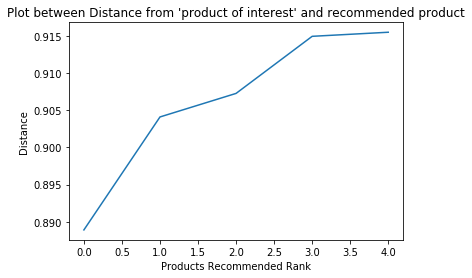

In [308]:
plt.plot(dist)
plt.ylabel('Distance')
plt.xlabel('Products Recommended Rank')
plt.title("Plot between Distance from 'product of interest' and recommended product")

###  Recommender Performance Testing using KNN supervised technique

In [317]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >=10]

In [318]:
dfCount.head()

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,...,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,totalReviewers,overallScore,summaryReview,UserID
415379,A1DTULED19K7HT,B0019EHU8G,"Abi ""abi""","[0, 0]",Bought for my ceiling mounted projector. As it...,5,Wonderful accessory,1331856000,"03 16, 2012",3435,...,3435,3435,3435,3435,3435,3435,3435,5,Wonderful accessory,"Abi ""abi"""
418762,A3CGQJYMSDLYAI,B0019EHU8G,yehe,"[0, 0]",This has been a great cord so far! I haven't h...,5,Great cord,1350691200,"10 20, 2012",3435,...,3435,3435,3435,3435,3435,3435,3435,5,Great cord,yehe
418685,AIWLW2OIJWOL2,B0019EHU8G,Wan,"[0, 0]",This is a GREAT High Speed HDMI cable at a GRE...,5,Great HDMI Cable!! As Good As or BETTER Than t...,1329868800,"02 22, 2012",3435,...,3435,3435,3435,3435,3435,3435,3435,5,Great HDMI Cable!! As Good As or BETTER Than t...,Wan
418765,A2HGW59S5IAVMA,B0019EHU8G,YM,"[0, 0]",I seriously will never buy another HDMI cable ...,5,The best,1390262400,"01 21, 2014",3435,...,3435,3435,3435,3435,3435,3435,3435,5,The best,YM
417073,A2FC76D8BXG0PR,B0019EHU8G,JPN850R,"[0, 1]",I bought this (25ft) to connect my notebook PC...,4,Works fine,1404604800,"07 6, 2014",3435,...,3435,3435,3435,3435,3435,3435,3435,4,Works fine,JPN850R


In [319]:
dfProductReview = data500.groupby("asin", as_index=False).mean() #mean
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
#ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [320]:
ProductReviewSummary.head()

,summaryReview
asin,
0972683275,"[It Works But Could Be Better, Excellent mount..."
1400501466,"[Excellent hardware, boot from SD for full tab..."
1400501520,"[Great product at a great price, Works Good No..."
1400501776,"[Good for education, This is amazing!, A gift ..."
1400532620,"[Nook, Great E-Reader 2012 and Nook Still Rock..."


In [321]:
dfProductReview.head()

,asin,overall,unixReviewTime
0,0528881469,2.400000,1.310515e+09
1,0594451647,4.200000,1.396328e+09
2,0594481813,4.000000,1.382789e+09
3,0972683275,4.461187,1.354240e+09
4,1400501466,3.953488,1.352373e+09


In [322]:
dfProductReview.shape

(19839, 3)

In [385]:
df = pd.read_csv("ProductReviewSummary.csv")
df = pd.merge(df, dfProductReview, on="asin", how='inner')

In [386]:
df.shape

(16927, 4)

In [387]:
df.head()

,asin,summaryReview,overall,unixReviewTime
0,0594481813,"['Great replacement for original power cable',...",4.000000,1.382789e+09
1,0972683275,['Excelant mount for Tv. Would buy more if I n...,4.461187,1.354240e+09
2,1400501466,"[""It's a entry-level tablet for $250"", 'amazin...",3.953488,1.352373e+09
3,1400501520,['B&N Nook 16 Gbs Tablet Has No Camera Can Pla...,4.400000,1.376261e+09
4,1400501776,"['Great Color E-Reader With Extra Features', ""...",4.150000,1.356627e+09


In [388]:
df=df.drop('unixReviewTime',axis=1)


In [389]:
df=df.rename(columns={'asin':'productID','overall':'avg_rating'})

In [390]:
df.head()

,productID,summaryReview,avg_rating
0,0594481813,"['Great replacement for original power cable',...",4.000000
1,0972683275,['Excelant mount for Tv. Would buy more if I n...,4.461187
2,1400501466,"[""It's a entry-level tablet for $250"", 'amazin...",3.953488
3,1400501520,['B&N Nook 16 Gbs Tablet Has No Camera Can Pla...,4.400000
4,1400501776,"['Great Color E-Reader With Extra Features', ""...",4.150000


In [391]:
df.shape

(16927, 3)

#### Text Cleaning - Summary column for KNN supervised recommender

In [392]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [393]:
#reset index and drop duplicate rows
df["summaryClean"] = df["summaryReview"].apply(cleanReviews)
#df = df.drop_duplicates(['overall'], keep='last')


In [394]:
df.head()

,productID,summaryReview,avg_rating,summaryClean
0,0594481813,"['Great replacement for original power cable',...",4.000000,great replacement for original power cable it ...
1,0972683275,['Excelant mount for Tv. Would buy more if I n...,4.461187,excelant mount for tv would buy more if i need...
2,1400501466,"[""It's a entry-level tablet for $250"", 'amazin...",3.953488,it s a entry level tablet for amazing device v...
3,1400501520,['B&N Nook 16 Gbs Tablet Has No Camera Can Pla...,4.400000,b n nook gbs tablet has no camera can play lim...
4,1400501776,"['Great Color E-Reader With Extra Features', ""...",4.150000,great color e reader with extra features know ...


In [395]:
df.columns

Index(['productID', 'summaryReview', 'avg_rating', 'summaryClean'], dtype='object')

In [396]:
reviews = df["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

In [397]:
transformedReviews.shape

(16927, 300)

In [398]:
transformedReviews.A[:4]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [399]:
dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [400]:
dfReviews.head()

,accessory,adapter,advertised,affordable,amazing,amazon,antenna,apple,audio,awesome,...,work,worked,working,works,worth,wow,wrong,year,years,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,0,0,5,0,1,0,0,0,0,7,...,3,3,0,24,1,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [401]:
#save 
dfReviews.to_csv("dfReviews.csv")

In [437]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [438]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

15234
1693


In [439]:
df_train_target = df["avg_rating"][:lentrain]
df_test_target = df["avg_rating"][lentrain:lentrain+lentest]
df_train_target = df_train_target.astype(int)
df_test_target = df_test_target.astype(int)

#### Predicting Review Rating with k = 3/5/7 ( using algo: ball_tree, kd_tree, brute)

In [449]:
#best result obtained with k=3
n_neighbors = [3,5,7]
algo=['ball_tree','kd_tree','brute']
values_accuracy=np.zeros((3,3))
values_RMSE=np.zeros((3,3))
for idx,i in enumerate(n_neighbors):
    for al,j in enumerate(algo):
        knnclf = neighbors.KNeighborsClassifier(i,algorithm=j, weights='distance')
        knnclf.fit(dfReviews_train, df_train_target)
        knnpreds_test = knnclf.predict(dfReviews_test)
        values_accuracy[idx,al]=accuracy_score(df_test_target, knnpreds_test)
        values_RMSE[idx,al]=sqrt(mean_squared_error(df_test_target, knnpreds_test))
#print(mean_squared_error(df5_test_target, knnpreds_test))

In [450]:
KNN_result_accuracy=pd.DataFrame(values_accuracy,index=n_neighbors,columns=algo)
KNN_result_RMSE=pd.DataFrame(values_RMSE,index=n_neighbors,columns=algo)

In [451]:
KNN_result_accuracy.head()

,ball_tree,kd_tree,brute
3,0.582989,0.582989,0.585351
5,0.608978,0.613703,0.614885
7,0.618429,0.611341,0.624335


In [452]:
KNN_result_RMSE.head()

,ball_tree,kd_tree,brute
3,0.764310,0.761988,0.758103
5,0.714379,0.709816,0.704806
7,0.703128,0.709400,0.693826


In [453]:
n_neighbors = 7
knnclf = neighbors.KNeighborsClassifier(n_neighbors,algorithm='brute',weights='distance')
knnclf.fit(dfReviews_train, df_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

In [454]:
print(accuracy_score(df_test_target, knnpreds_test))

0.6243354991139988


In [455]:
print(sqrt(mean_squared_error(df_test_target, knnpreds_test)))

0.6938256086308482


#### Get recommendations:

In [440]:
neighbor = NearestNeighbors(n_neighbors=7, algorithm='brute').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [443]:
i=np.random.choice(lentest)
a = neighbor.kneighbors([dfReviews_test[i]])
related_product_list = a[1]

first_related_product = [item[0] for item in related_product_list]
first_related_product = str(first_related_product).strip('[]')
first_related_product = int(first_related_product)
second_related_product = [item[1] for item in related_product_list]
second_related_product = str(second_related_product).strip('[]')
second_related_product = int(second_related_product)
    
    
print ("Based on product reviews, for ", df["productID"][lentrain + i] ," average rating is ",df["avg_rating"][lentrain + i])
print ("The first similar product is ", df["productID"][first_related_product] ," average rating is ",df["avg_rating"][first_related_product])
print ("The second similar product is ", df["productID"][second_related_product] ," average rating is ",df["avg_rating"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B001H5WLP4  average rating is  4.111111111111111
The first similar product is  B0002J4IX4  average rating is  4.5
The second similar product is  B000L9M0YO  average rating is  4.857142857142857
-----------------------------------------------------------


#### WordCloud

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [237]:
cluster = data500.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

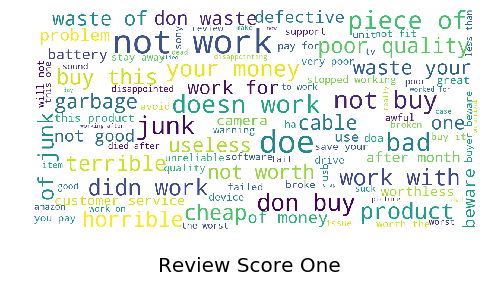

In [240]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

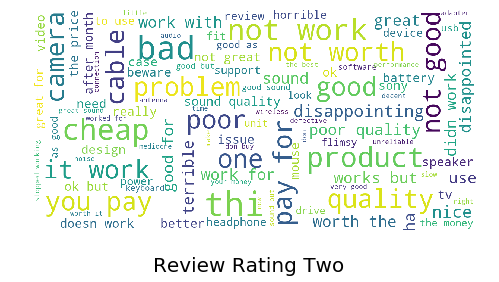

In [241]:
show_wordcloud(cluster1["summaryClean"][1], title = "Review Rating Two")

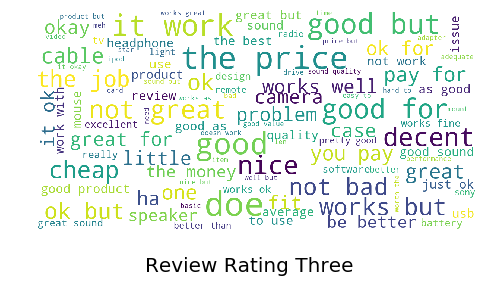

In [242]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Rating Three")

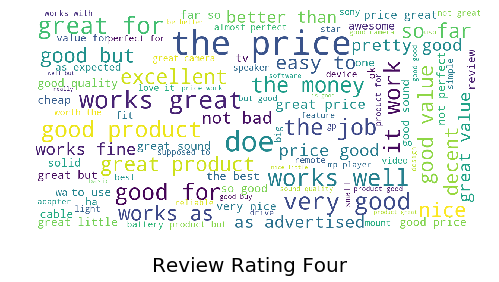

In [243]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Rating Four")

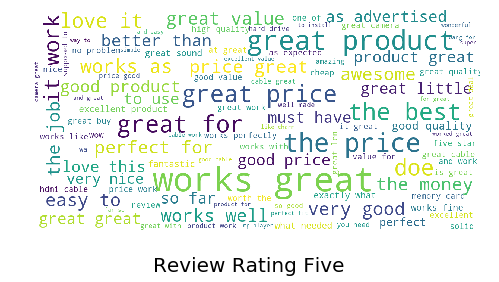

In [244]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Rating Five")

# 2. Sentiment Analysis using LSTM Neural Network

#### Import libraries

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import time 
from tensorflow.keras.layers import Dropout

Using TensorFlow backend.


In [31]:
from keras.layers import Bidirectional

In [32]:
from keras.layers import Activation

#### Load Data

In [539]:
import pandas as pd
first500=pd.read_json('500data.json',lines=True)

In [540]:
data=first500[['summary','overall']]

In [541]:
data.head()

,summary,overall
0,Gotta have GPS!,5
1,Very Disappointed,1
2,1st impression,3
3,"Great grafics, POOR GPS",2
4,"Major issues, only excuses for support",1


In [542]:
data['sentiment']= ['Positive' if x>=3 else 'Negative' for x in data['overall']]

In [543]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(summary):
    summary = summary.lower()
    summary = regEx.sub(' ', summary).strip()
    return summary

In [544]:
data["summaryClean"] = data["summary"].apply(cleanReviews)

In [545]:
data.head()

,summary,overall,sentiment,summaryClean
0,Gotta have GPS!,5,Positive,gotta have gps
1,Very Disappointed,1,Negative,very disappointed
2,1st impression,3,Positive,st impression
3,"Great grafics, POOR GPS",2,Negative,great grafics poor gps
4,"Major issues, only excuses for support",1,Negative,major issues only excuses for support


In [546]:
data['length']=data['summaryClean'].apply(lambda x: len(x.split()))

In [547]:
data.head()

,summary,overall,sentiment,summaryClean,length
0,Gotta have GPS!,5,Positive,gotta have gps,3
1,Very Disappointed,1,Negative,very disappointed,2
2,1st impression,3,Positive,st impression,2
3,"Great grafics, POOR GPS",2,Negative,great grafics poor gps,4
4,"Major issues, only excuses for support",1,Negative,major issues only excuses for support,6


In [548]:
data['length'].max()

29

#### WordTokenizer

In [549]:
#I have considered a rating equal or above 3 as positive and less than 3 as negative.

tokenizer = Tokenizer(num_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(data['summaryClean'].values)
#print(tokenizer.word_index)  # To see the dictionary
X = tokenizer.texts_to_sequences(data['summaryClean'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)

In [550]:
X.shape

(500000, 29)

### Model

In [551]:
tokenizer = Tokenizer(num_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(data['summaryClean'].values)
#print(tokenizer.word_index)  # To see the dicstionary
X2 = tokenizer.texts_to_sequences(data['summaryClean'].values)
X2 = pad_sequences(X2,padding=padding_type)

Y2 = pd.get_dummies(data['sentiment']).values
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X2,Y2, test_size = 0.20, random_state = 36)

vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

embed_dim = 100
lstm_out = 200
batch_size = 32

model2 = Sequential()
model2.add(Embedding(2500, embed_dim,input_length = X2.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout= 0.2, recurrent_dropout = 0.2,return_sequences=True))
model2.add(LSTM(64, dropout= 0.2, recurrent_dropout = 0.2,return_sequences=True))
model2.add(Bidirectional(LSTM(32,activation='relu')))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 29, 100)           250000    
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 29, 100)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 29, 100)           80400     
_________________________________________________________________
lstm_50 (LSTM)               (None, 29, 64)            42240     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 397,602
Trainable params: 397,602
Non-trainable params: 0
_______________________________________________

In [164]:
history_model2 = model2.fit(X_train, Y_train, epochs=10, validation_data=(X_valid,Y_valid), verbose=2)

Train on 400000 samples, validate on 100000 samples
Epoch 1/10
 - 487s - loss: 0.1992 - accuracy: 0.9226 - val_loss: 0.1859 - val_accuracy: 0.9276
Epoch 2/10
 - 485s - loss: 0.1784 - accuracy: 0.9298 - val_loss: 0.1812 - val_accuracy: 0.9292
Epoch 3/10
 - 485s - loss: 0.1729 - accuracy: 0.9318 - val_loss: 0.1767 - val_accuracy: 0.9299
Epoch 4/10
 - 484s - loss: 0.1736 - accuracy: 0.9333 - val_loss: 0.1781 - val_accuracy: 0.9309
Epoch 5/10
 - 484s - loss: 0.1666 - accuracy: 0.9339 - val_loss: 0.1784 - val_accuracy: 0.9310
Epoch 6/10
 - 484s - loss: 0.1661 - accuracy: 0.9346 - val_loss: 0.1757 - val_accuracy: 0.9308
Epoch 7/10
 - 485s - loss: 0.1629 - accuracy: 0.9357 - val_loss: 0.1756 - val_accuracy: 0.9309
Epoch 8/10
 - 484s - loss: 0.1618 - accuracy: 0.9360 - val_loss: 0.1778 - val_accuracy: 0.9310
Epoch 9/10
 - 485s - loss: 0.1599 - accuracy: 0.9363 - val_loss: 0.1839 - val_accuracy: 0.9284
Epoch 10/10
 - 485s - loss: 0.3023 - accuracy: 0.9370 - val_loss: 0.1755 - val_accuracy: 0.93

### Model 2 with epochs=2 has been selected and now being trained 

In [552]:
model2.fit(X_train, Y_train, batch_size =batch_size, epochs =2,  verbose = 2)

Epoch 1/2
 - 468s - loss: 0.2004 - accuracy: 0.9215
Epoch 2/2
 - 467s - loss: 0.1811 - accuracy: 0.9298


In [553]:
loss2,acc2=model2.evaluate(X_valid,Y_valid,verbose=2,batch_size=batch_size)
print(f"loss {loss2} and accuracy is {acc2}")

loss 0.18293609483122825 and accuracy is 0.9290400147438049


### Testing model2 with Unseen Data of 1.1M

In [555]:
unseen=pd.read_json('unseenamazon.json',lines=True)

In [556]:
unseen=unseen[['summary','overall']]

In [557]:
unseen['sentiment']= ['Positive' if x>=3 else 'Negative' for x in unseen['overall']]

In [558]:
unseen["summaryClean"] = unseen["summary"].apply(cleanReviews)

In [559]:
unseen.head()

,summary,overall,sentiment,summaryClean
0,Great Case!,5,Positive,great case
1,Perfectly good for what it is,5,Positive,perfectly good for what it is
2,Just perfect if you prefer to handle the Kindl...,5,Positive,just perfect if you prefer to handle the kindl...
3,Just what I wanted and needed for my K2,5,Positive,just what i wanted and needed for my k
4,Great product,5,Positive,great product


In [560]:
tokenizer = Tokenizer(num_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(unseen['summaryClean'].values)
#print(tokenizer.word_index)  # To see the dictionary
X_unseen = tokenizer.texts_to_sequences(unseen['summaryClean'].values)
X_unseen = pad_sequences(X_unseen)

In [561]:
Y_unseen = pd.get_dummies(unseen['sentiment']).values

In [562]:
loss2,acc2=model2.evaluate(X_unseen,Y_unseen,verbose=2,batch_size=batch_size)
print(f"loss {loss2} and accuracy is {acc2}")

loss 0.4415528351801092 and accuracy is 0.8874545693397522


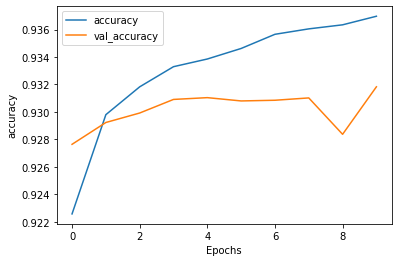

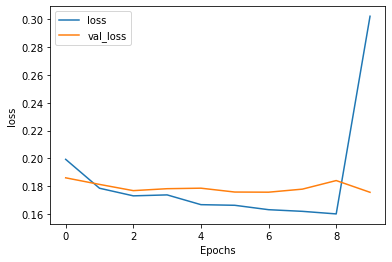

In [190]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history_model2, "accuracy")
plot_graphs(history_model2, "loss")

# 3. Recommenders!! ( Content Based)

In [165]:
required_metadata=pd.read_csv('required_metadata_amazon.csv')
required_metadata.head()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,also_buy,also_view,asin,brand,category,date,description,details,feature,fit,image,main_cat,price,rank,similar_item,tech1,tech2,title
0,40,NaN,"['B00RVGXZBM', 'B00N58RZ34', 'B07FKR7VZ4', 'B0...",0528881469,Rand McNally,"['Electronics', 'GPS, Finders & Accessories', ...","April 15, 2010",['**** Shipped by 2-3 DAY UNITED STATES PRIORI...,NaN,"['Extra large 7-inch high-definition screen', ...",NaN,['https://images-na.ssl-images-amazon.com/imag...,All Electronics,NaN,>#60 in Electronics > GPS & Navigation > Vehic...,NaN,NaN,NaN,Rand McNally 528881469 7-inch Intelliroute TND...
1,84,NaN,"['B00RRFMVEE', 'B01N5F6RNV', '1400699169', 'B0...",0594451647,Barnes &amp; Noble,"['Electronics', 'Computers & Accessories', 'Ta...","May 28, 2013","[""HDTV Adapter Kit for NOOK HD and NOOK HD+\nT...",NaN,['Connects NOOK to your high-definition televi...,NaN,['https://images-na.ssl-images-amazon.com/imag...,Home Audio & Theater,$1.46,"['>#1,708 in Computers & Accessories > Tablet ...","[{'asin': '', 'href': '', 'name': 'Barnes & No...",NaN,NaN,Barnes & Noble HDTV Adapter Kit for NOOK HD an...
2,201,"['B000WYVBR0', 'B003O1UYHG', 'B002YV4WJS', 'B0...",NaN,0972683275,VideoSecu,"['Electronics', 'Accessories & Supplies', 'Aud...","February 25, 2007",['The videosecu TV mount is a mounting solutio...,NaN,"['Fits most 22"" to 47"" HDTV and some up to 55""...",NaN,['https://images-na.ssl-images-amazon.com/imag...,All Electronics,$34.99,>#176 in Electronics > Accessories & Supplies ...,"[{'asin': '', 'href': '', 'name': 'VideoSecu 2...",NaN,NaN,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi..."
3,461,NaN,"['B077Y84B2C', '140053271X', '1400532655', 'B0...",1400599997,Barnes &amp; Noble,"['Electronics', 'eBook Readers & Accessories',...","November 25, 2009",['Choose an eBook using the beautiful color to...,NaN,"['Barnes & Noble brand ebook reader: Nook', 'E...",NaN,['https://images-na.ssl-images-amazon.com/imag...,All Electronics,NaN,">#41,296 in Electronics (See Top 100 in Electr...","[{'asin': '', 'href': '', 'name': 'Barnes & No...",NaN,NaN,Barnes & Noble NOOK ebook reader (WiFi + 3G)[B&W]
4,463,"['B016F1SVVM', '1616855711', 'B00KBPQHMO', '16...","['B077Y84B2C', '1400501717', 'B00L89V1AA', 'B0...",140053271X,Barnes &amp; Noble,"['Electronics', 'eBook Readers & Accessories',...","June 3, 2011","[""The NOOK Simple Touch eReader allows you to ...",NaN,"['Box Content - eReader, microUSB Cable, Start...",NaN,['https://images-na.ssl-images-amazon.com/imag...,Home Audio & Theater,NaN,">#58,105 in Electronics (See Top 100 in Electr...","[{'asin': '', 'href': '', 'name': 'Barnes & No...",NaN,NaN,Barnes & Noble Nook Simple Touch eBook Reader ...


In [212]:
required_metadata.shape

(44241, 19)

In [213]:
required_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44241 entries, 0 to 44240
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    44241 non-null  int64 
 1   also_buy      8885 non-null   object
 2   also_view     23766 non-null  object
 3   asin          44241 non-null  object
 4   brand         44158 non-null  object
 5   category      44241 non-null  object
 6   date          40046 non-null  object
 7   description   41659 non-null  object
 8   details       1063 non-null   object
 9   feature       41046 non-null  object
 10  fit           3 non-null      object
 11  image         30433 non-null  object
 12  main_cat      44196 non-null  object
 13  price         18413 non-null  object
 14  rank          43417 non-null  object
 15  similar_item  23646 non-null  object
 16  tech1         10012 non-null  object
 17  tech2         3978 non-null   object
 18  title         44241 non-null  object
dtypes: i

In [167]:
#Select required columns
meta=required_metadata[['asin','title','feature']]

In [169]:
meta.head()

,asin,title,feature
0,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,"['Extra large 7-inch high-definition screen', ..."
1,0594451647,Barnes & Noble HDTV Adapter Kit for NOOK HD an...,['Connects NOOK to your high-definition televi...
2,0972683275,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...","['Fits most 22"" to 47"" HDTV and some up to 55""..."
3,1400599997,Barnes & Noble NOOK ebook reader (WiFi + 3G)[B&W],"['Barnes & Noble brand ebook reader: Nook', 'E..."
4,140053271X,Barnes & Noble Nook Simple Touch eBook Reader ...,"['Box Content - eReader, microUSB Cable, Start..."


In [182]:
#Make feature column of type string
meta['feature']=meta['feature'].astype('str')


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [215]:
meta.head()

,asin,title,feature
0,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...,"['Extra large 7-inch high-definition screen', ..."
1,0594451647,Barnes & Noble HDTV Adapter Kit for NOOK HD an...,['Connects NOOK to your high-definition televi...
2,0972683275,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...","['Fits most 22"" to 47"" HDTV and some up to 55""..."
3,1400599997,Barnes & Noble NOOK ebook reader (WiFi + 3G)[B&W],"['Barnes & Noble brand ebook reader: Nook', 'E..."
4,140053271X,Barnes & Noble Nook Simple Touch eBook Reader ...,"['Box Content - eReader, microUSB Cable, Start..."


In [187]:
# import require library
from sklearn.feature_extraction.text import TfidfVectorizer

In [188]:
#create an instance of the TfidfVectorizer
tvf=TfidfVectorizer(min_df=3,strip_accents='unicode',analyzer='word',ngram_range=(1,3))

In [ ]:
#fill any Nan values in feature item
meta['feature']=meta['feature'].fillna('')

In [189]:
#tvf matrix for features of different products
tvf_matrix=tvf.fit_transform(meta['feature'])

In [190]:
tvf_matrix.shape

(44241, 281161)

In [193]:
#import sigmoid kernel for similarity matrix between products
from sklearn.metrics.pairwise import sigmoid_kernel

In [194]:
#create similarity matrix
sig=sigmoid_kernel(tvf_matrix,tvf_matrix)

In [195]:
#checking first product similarity with others
sig[0]

array([0.76159565, 0.76159421, 0.76159417, ..., 0.76159417, 0.76159417,
       0.76159417])

In [196]:
#creating a series to keep track of the titles of the products.
indices=pd.Series(meta.index,index=meta['title'])

In [205]:
#testing
print(indices[:4],'\n')

title
Rand McNally 528881469 7-inch Intelliroute TND 700 Truck GPS                                                                                                                                                0
Barnes & Noble HDTV Adapter Kit for NOOK HD and NOOK HD+                                                                                                                                                    1
VideoSecu 24" Long Arm TV Wall Mount Low Profile Articulating Full Motion Cantilever Swing Tilt wall bracket for most 22" to 55" LED LCD TV Monitor Flat Screen VESA 200x200 400x400 up to 600x400mm MAH    2
Barnes & Noble NOOK ebook reader (WiFi + 3G)[B&W]                                                                                                                                                           3
dtype: int64 



### Gives recommendation on any clicked product

In [209]:
#Function that gives recommendation based on similarity of features.
def give_recommendation (title,sig=sig):
    
    #get the index of the product (title) from indices series
    idx=indices[title]
    
    #Look for this index in sig similarity matrix
    sig_score=list(enumerate(sig[idx]))
    
    #sort the obtained row for most related product on top
    sig_score=sorted(sig_score,key=lambda x: x[1],reverse=True)
    
    #Get top 5 products information
    sig_score=sig_score[1:6]
    
    #get the list of indices with first column of sig_score
    product_idx=[i[0] for i in sig_score]
    
    #put this list in the main dataset to get the titles of most similar products.
    return meta['title'].iloc[product_idx]

In [210]:
give_recommendation('Rand McNally 528881469 7-inch Intelliroute TND 700 Truck GPS')

34968    Rand McNally TND 720 LM IntelliRoute Truck GPS...
37670    Garmin Dezl 760LMT 7-Inch Bluetooth Trucking G...
31436    Magellan RoadMate Pro 9165T - 7-Inch GPS Navig...
35821    Magellan RoadMate RV9165T-LM 7-Inch RV GPS Nav...
35822    Magellan RoadMate RV9145-LM - 7-Inch GPS Navig...
Name: title, dtype: object